In [2]:
# IMPORTACIONES     

import os

from dataclasses import dataclass

import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms  # Asegurate de importar esto
from torchvision import datasets, transforms
from torchvision.datasets  import EuroSAT
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import models

import random

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [3]:
# establezco directorio

import os

path = 'C:/Users/flore/OneDrive/Escritorio/GICA/EuroSAT/2750'
carpetas = os.listdir(path)
print(carpetas)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/flore/OneDrive/Escritorio/GICA/EuroSAT/2750'

In [ ]:
# EXPLORACION DE DATOS 

class EuroSat:
    path: str
    
    def cargar_imagen(self, carpeta: str, nombre_imagen: str) -> np.array:
        """
        Carga una imagen específica desde el directorio indicado.
        """
        img_path = os.path.join(self.path, carpeta, nombre_imagen)
        img = Image.open(img_path)
        img_array = np.array(img)
        return img_array
    
    def obtener_clases(self) -> list:
        """
        Devuelve una lista con los nombres de las clases (carpetas) del conjunto de datos.
        """
        return os.listdir(self.path)

    def mostrar_imagen(self, img_array: np.array, titulo: str = "Imagen"):
        """
        Muestra la imagen usando matplotlib.
        """
        import matplotlib.pyplot as plt
        plt.imshow(img_array)
        plt.title(titulo)
        plt.axis("off")
        plt.show()

In [ ]:
# CARGA DE DATASET

# importo 'torch.utils.data', que contiene la clase Dataset'que estoy intentando usar.

import torch
from torch.utils.data import Dataset
from PIL import Image
import os

     
# Defino el conjunto de datos a utilizar en PyTorch (custom dataset)
class EuroSAT(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Inicializa el dataset EuroSAT.
        
        :param dataset: El conjunto de datos (por ejemplo, una lista de tuplas (imagen, etiqueta))
        :param transform: Transformaciones que se aplicarán a las imágenes (si las hay)
        """
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        """
        Devuelve una imagen y su etiqueta correspondiente.
        
        param index: El índice de la imagen que se quiere cargar
        """
        # Obtener la imagen
        img, label = self.dataset[index]
                
        
        
        # Aplicar transformaciones si se han proporcionado
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def __len__(self):
        """
        Devuelve el número total de elementos en el dataset.
        """
        return len(self.dataset)


In [ ]:
# AUMENTO DE DATOS

# Aumento de Datos
## El aumento de datos es una técnica que aplica aleatoriamente transformaciones de imagen, 
# como recortes, volteos horizontales y verticales a las imágenes de entrada durante el 
# entrenamiento del modelo. Estas perturbaciones reducen el sobreajuste de la red neuronal 
# al conjunto de datos de entrenamiento y le permiten generalizar mejor al conjunto de 
# datos de prueba no analizado.

import torchvision
from torchvision import transforms  # Asegurate de importar esto

input_size = 224  ### ACÁ PUEDO METER MANO: Parámetro modificable: input_size = 224
                 # Este define el tamaño final de tus imágenes.
                # Si vas a usar modelos como ResNet, VGG, etc., entrenados en ImageNet, 224x224 es el tamaño estándar.
                # Podés cambiarlo si estás trabajando con un modelo personalizado o si querés experimentar con resoluciones distintas (por ejemplo, 128 o 256), aunque eso puede impactar el rendimiento del modelo (en velocidad o precisión).
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# Normalización de imágenes
##Además, en la celda inferior, el método transforms.Normalize normaliza cada uno de los 
# tres canales según las medias y desviaciones estándar definidas en las variables 
# imagenet_mean e imagenet_std. ImageNet es un conjunto de datos de entrenamiento 
# de imágenes y etiquetas. Más adelante en este tutorial, utilizaremos un modelo 
# preentrenado con este conjunto de datos. Para utilizar este modelo preentrenado con 
# nuestro conjunto de datos LULC, debemos asegurarnos de que el conjunto de datos de 
# entrada esté normalizado para tener las mismas estadísticas (media y desviación estándar) 
# que ImageNet.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [ ]:
# TRANSFORMACIONES 

from torchvision.datasets  import EuroSAT

from torch.utils.data import Subset


# Aplica diferentes transformaciones al conjunto de entrenamiento y prueba
train_dataset = EuroSAT(root='data/', download=True, transform=train_transform)  
test_dataset = EuroSAT(root='data/', download=True, transform=train_transform)   

# Divide aleatoriamente el conjunto de datos (80% entrenamiento, 20% prueba)
 
 
train_size = 0.8
indices = list(range(len(train_dataset)))
split = int(train_size * len(train_dataset))

"""
FIJAR SEMILLA
acá fijo la semilla para garantizar la reproducibilidad
np.random.seed(42)  # o el número que quiera

>>> al fijar semilla garantizo que la desición de datos sea siempre la misma.
de esta manera los experimentos serán reproducibles (en estadística esto sería 
el nro réplica).

> los experimentos serán reproducibles: si alguien más corre el cógiso (o yo en 
el futuro) se verán los mismos resultados.

> es ideal para comparar parámetros, modelos, etc. bajo las mismas condiciones.
>>> por ej. acá yo quiero comparar el index y otros parámetros para ver cómo
varían segpun mi propio seteo, entonces me conviene fijar una semilla.

Reproducibilidad completa (en Pytorch):
import torch
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Resumen: 
Fijar la semilla = asegurarte de que el experimento que corrés hoy, se pueda 
repetir mañana con los mismos resultados.

"""


np.random.shuffle(indices)

train_data = Subset(train_dataset, indices[:split])
test_data = Subset(test_dataset, indices[split:])

print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))


100%|██████████| 94.3M/94.3M [00:11<00:00, 8.54MB/s]


Train/test sizes: 21600/5400


In [ ]:
"""" opcional: ColorJitter: transformación que altera brillo, contraste, saturación y matiz de la imagen.

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

    - brightness=0.2 → cambia el brillo ±20%

    - contrast=0.2 → cambia el contraste ±20%

    - saturation=0.2 → cambia la saturación ±20%

    - hue=0.1 → cambia el tono (color) ±10%

👉 Útil cuando las imágenes tienen variaciones de iluminación (como fotos al aire libre, distintas cámaras, etc).
"""


In [ ]:
# DATALOADER
# Usamos la clase `DataLoader` de `torch` para crear un cargador de datos. 
### gestiona la obtención de muestras de los conjuntos de datos y ensambla 
# lotes de los conjuntos de datos.

from torch.utils.data import DataLoader

num_workers = 2   # cuantos procesos paralelos se usan para leer los datos del disco
                 # CPU con varios npucleos aceleran el data loading
                 
                 
batch_size = 16    ## cuantas imágenes procesa a la vez
                   ## Nro imagen= 8000 >> 8000/16= 500 batches por época
                   ## si la GPU tiene más memoria puedo aumentar el batch
                   ## size y entrenar más rápido.

train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)   

#shuffle=true: mezcla los datos al inicio de cada época. Ayuda a que el modelo 
# NO aprenda un ORDEN DE DATOS

test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

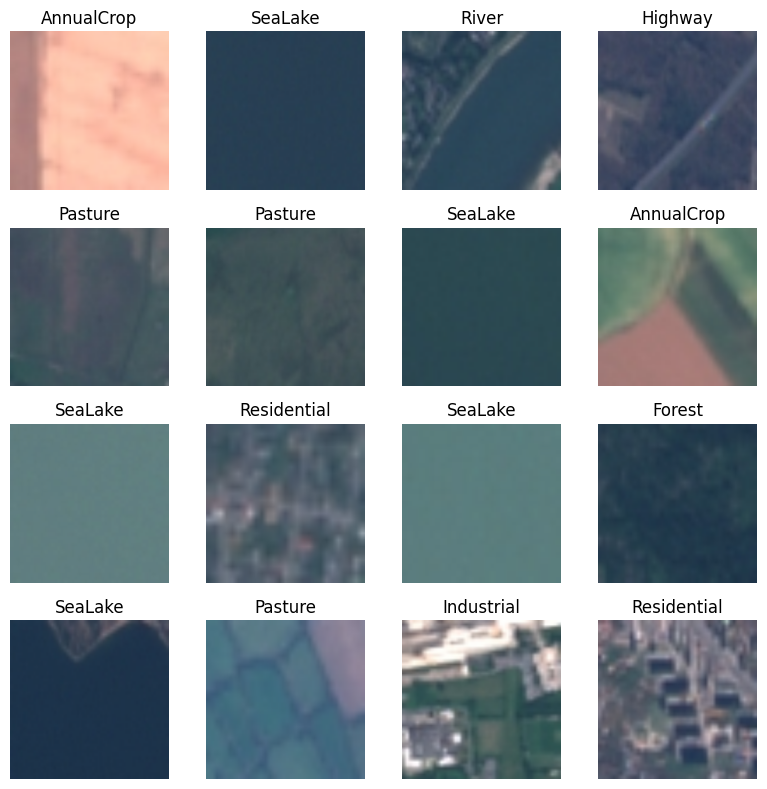

In [ ]:
# VISUALIZACION

### se visualiza un lote (batch) del conjunto de datos.. La celda visualiza la entrada a la
### red neuronal (imagen RGB) junto con la etiqueta de datos.

import matplotlib.pyplot as plt
import numpy as np

# Asumimos que 'class_names' es una lista de las clases de EuroSAT
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 
    'River', 'SeaLake'
]

# Tomamos un batch del DataLoader
n = 4  # Cuántas imágenes por fila y columna
inputs, classes = next(iter(train_loader))

# Preparamos el gráfico
fig, axes = plt.subplots(n, n, figsize=(8, 8))

# Visualizamos las imágenes
for i in range(n):
    for j in range(n):
        # Obtenemos la imagen
        image = inputs[i * n + j].numpy().transpose((1, 2, 0))
        
        # Desnormalizamos la imagen
        image = np.clip(image * np.array(imagenet_std) + np.array(imagenet_mean), 0, 1)
        
        # Título con el nombre de la clase
        title = class_names[classes[i * n + j]]
        
        # Mostrar la imagen
        axes[i, j].imshow(image)
        axes[i, j].set_title(title)
        axes[i, j].axis('off')  # Quita los ejes para mejor presentación

# Muestra el gráfico
plt.tight_layout()
plt.show()



{'AnnualCrop': 2413, 'Forest': 2392, 'HerbaceousVegetation': 2421, 'Highway': 2012, 'Industrial': 2002, 'Pasture': 1600, 'PermanentCrop': 1972, 'Residential': 2365, 'River': 2028, 'SeaLake': 2395}


C:\Users\flore\AppData\Local\Temp\ipykernel_18624\169383744.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df, palette='viridis')


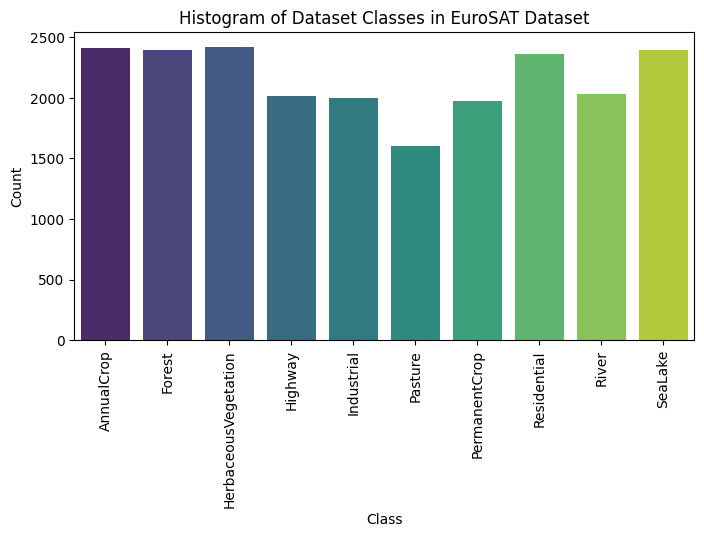

' este grafico dará una distribución de clases en mi conjunto de datos, \nmostrando cuantas imágenes tiene cada categoría.\n\nSi hay over-samplig o under-sampling, se pueden pensar en técnicas de \nbalanceo del dataset\n'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Primero, obtenemos las clases (labels) y sus frecuencias
class_counts = [0] * len(class_names)

# Contamos cuántas imágenes hay de cada clase en el train_dataset 
# (conjunto de entrenamiento)
for _, label in train_data:
    class_counts[label] += 1
    
# Imprimimos estadísticas de conteo por clase: Esto te dará el número de 
# imágenes por cada clase, y podrás ver si hay grandes discrepancias entre 
# las clases.
class_stats = {class_names[i]: count for i, count in enumerate(class_counts)}
print(class_stats) 


# Creamos un DataFrame para la visualización: utilizo Pandar para crear un 
# DataFrame (es más fácil de manejar con seaborn)
import pandas as pd
df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Plot del barplot: acá cambié el histograma (datos contínuos) por barplot 
# (frecuencia de categorías discretas)
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', data=df, palette='viridis')

# Rotación de categorías y títulos: visualización mejorada con rotación de 
# etiquetas
plt.xticks(rotation=90)
plt.title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()


""" este grafico dará una distribución de clases en mi conjunto de datos, 
mostrando cuantas imágenes tiene cada categoría.

Si hay over-samplig o under-sampling, se pueden pensar en técnicas de 
balanceo del dataset
"""

In [ ]:
from torchvision import datasets, transforms
# Load the 
data_dir = 'C:/Users/flore/OneDrive/Escritorio/GICA/EuroSAT/2750'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [ ]:
# DEFINICION  DEL MODELO
# RESNET-50
import torchsummary
from torchvision import models
from torch.utils.data import Dataset

model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# !pip install scikit-learn ### si es necesario instalar la librería

In [ ]:
# ENRTENAMIENTO CON EARLY STOPPING

# ACA EMPIEZO CON EL MODULO DE ENTRENAMIENTO CON METRICAS + EARLY STOPPING +  GRAFICOS

# Importo los modulos necesarios

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import random

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from torchvision import models

In [ ]:
# EARLY CLASS STOPPING

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path="checkpoint.pth"):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                return True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        return False

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss improved. Saving model...')
        torch.save(model.state_dict(), self.path)

In [ ]:
# EVALUACION DEL MODELO Y VISUALIZACION ; GUARDAR METRICAS

from sklearn.metrics import precision_score, recall_score, f1_score

    # Evaluacion del modelo
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()

            _, top1_preds = torch.max(outputs, 1)
            _, top5_preds = outputs.topk(5, dim=1)

            correct_top1 += (top1_preds == labels).sum().item()
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top1_preds.cpu().numpy())
    
    # Visualizacion

    val_accuracy = correct_top1 / total
    val_top5_acc = correct_top5 / total
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    avg_loss = val_loss / len(dataloader)

    return val_accuracy, val_top5_acc, precision, recall, f1, avg_loss


def plot_metrics(metrics_dict):
    epochs = range(1, len(next(iter(metrics_dict.values()))) + 1)
    plt.figure(figsize=(18, 10))
    titles = {
        'val_accuracies': 'Accuracy',
        'val_top5_accuracies': 'Top-5 Accuracy',
        'val_f1_scores': 'F1 Score',
        'val_precisions': 'Precision',
        'val_recalls': 'Recall'
    }
    for i, (key, values) in enumerate(metrics_dict.items(), 1):
        plt.subplot(2, 3, i)
        plt.plot(epochs, values, label=titles[key])
        plt.xlabel("Epoch")
        plt.ylabel(titles[key])
        plt.title(f"{titles[key]} por Época")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    y_true= [] 
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap='Blues', colorbar=False)
    plt.title("Matriz de Confusión")
    plt.show()


In [ ]:
# ENTRENAMIENTO Y VALIDACION

###  Definir optimizador y scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

### EarlyStopping: Iniciar el controlador
early_stopping = EarlyStopping(patience=5, verbose=True, path="best_model.pth")

### Inicializo las metricas
val_losses= []
val_accuracies= []
val_top5_accuracies = []
val_precisions= []
val_recalls= []
val_f1_scores = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Establece el modelo en modo de entrenamiento
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Evaluación
    val_loss, val_acc, top5_acc, precision, recall, f1 = evaluate_model(model, test_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_top5_accuracies.append(top5_acc)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {f1:.4f}")

    if early_stopping(val_loss, model):
         
        break

    scheduler.step()

KeyboardInterrupt: 

In [ ]:
# VISUALIZACION: grafico metricas por epocas

### Creo la funcion para graficar metricas por epoca

import matplotlib.pyplot as plt

def plot_metrics(metrics_dict):
    epochs = range(1, len(next(iter(metrics_dict.values()))) + 1)
    plt.figure(figsize=(18, 10))

    titles = {
        'val_accuracies': 'Accuracy',
        'val_top5_accuracies': 'Top-5 Accuracy',
        'val_f1_scores': 'F1 Score',
        'val_precisions': 'Precision',
        'val_recalls': 'Recall'
    }

    for i, (key, values) in enumerate(metrics_dict.items(), 1):
        plt.subplot(2, 3, i)
        plt.plot(epochs, values, label=titles[key])
        plt.xlabel("Epoch")
        plt.ylabel(titles[key])
        plt.title(f"{titles[key]} por Época")
        plt.grid(True)

    plt.tight_layout() 
    

### Uso la funcion creada asi: 

plot_metrics({
    'val_accuracies': val_accuracies,
    'val_top5_accuracies': val_top5_accuracies,
    'val_f1_scores': val_f1_scores,
    'val_precisions': val_precisions,
    'val_recalls': val_recalls
})

plot_confusion_matrix(model, test_loader, dataset.classes, device)

In [ ]:
# ARMO LISTAS PARA GUARDAR LA METRICAS POR EPOCA

val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_top5_accuracies = []

 # Métricas por época
    val_accuracy = correct_top1 / total
    val_top5_acc = correct_top5 / total
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Guardar métricas
    val_accuracies.append(val_accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    val_top5_accuracies.append(val_top5_acc)
    
    # Mostrar por consola
    print(f"Val Accuracy: {val_accuracy:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Top-5 Acc: {val_top5_acc:.4f}")
    
        # Calcular la pérdida promedio en el conjunto de validación
    val_loss = val_loss / len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss}')
    

In [ ]:
# AL FINAL DEL ENTRENAMIENTO GRAFICO TODAS LAS METRICAS

epochs = range(1, len(val_accuracies) + 1)

plt.figure(figsize=(18, 10))

# Accuracy
plt.subplot(2, 3, 1)
plt.plot(epochs, val_accuracies, label='Top-1 Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy por Época")
plt.grid(True)

# Top-5 Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, val_top5_accuracies, label='Top-5 Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.title("Top-5 Accuracy por Época")
plt.grid(True)

# F1 Score
plt.subplot(2, 3, 3)
plt.plot(epochs, val_f1_scores, label='F1 Score', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 por Época")
plt.grid(True)

# Precision
plt.subplot(2, 3, 4)
plt.plot(epochs, val_precisions, label='Precision', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision por Época")
plt.grid(True)

# Recall
plt.subplot(2, 3, 5)
plt.plot(epochs, val_recalls, label='Recall', color='red')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall por Época")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# MATRIZ DE CONFUSION

# Al final, sobre el conjunto completo de test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hago predicciones en test
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap='Blues', colorbar=False)
    plt.title("Matriz de Confusión")
    plt.show()

# uso la función así
plot_confusion_matrix(model, test_loader, dataset.classes, device)
